# # [Amet Vikram]
# # ECE 539 : Term Project
# # Dataset 2 : Air Quality

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("AirQualityUCI.csv",sep=";", decimal=",",header=0)

In [3]:
display(df.head())

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN          NaN  
1  13.3  47.7  0.7255          NaN          NaN  
2  11.9  54.0  0.7502          NaN          NaN  
3  11.0  60.0  0.7867          NaN          NaN  
4  11.2  59.6  0.7888          NaN          NaN

## Data Analysis and Exploration

<h4>Premilinary Analysis</h4>

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB
None

<p>Now from above analysis, we can observe that there are two columns that are <strong>completely empty</strong> and so we will drop these columns.</p>
<p>There are <strong>two temporal features</strong> present in the dataset as <strong>Date</strong> and <strong>Time</strong>, we will convert these features into one column as <strong>DateTime</strong>, to carry out <strong>time series analysis.</strong></p>
<p>There are <strong>no categorical columns</strong> present in the dataset.</p>
<p>Additonally, there is no target feature in the dataset and so we will use the potential pollutant feature columns,&nbsp;<strong>CO(GT)&nbsp;</strong>and&nbsp;<strong>PT08.S1(CO)</strong>, as <strong>two separate target features.</strong></p>

In [5]:
target_class = pd.Index(["CO(GT)", "PT08.S1(CO)"])

features_drop = pd.Index(["Unnamed: 15","Unnamed: 16"])

num_cols = df.columns[2:15]

df = df.drop(features_drop,axis=1)

print(num_cols)
print("\n")

print(target_class)
print("\n")

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')


Index(['CO(GT)', 'PT08.S1(CO)'], dtype='object')




In [6]:
display(df.head())

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

<h4>Null value Analysis</h4>

<p>Now based on the dataset description, it can be noted that it is mentioned that <strong>"Missing values are tagged with -200 value"</strong>, and so we will have to first replace the missing values and then proceed with the analysis.</p>
<p><strong>Bibliography:</strong> <a href="https://archive.ics.uci.edu/dataset/360/air+quality">Dataset description</a></p>

In [7]:
df = df.replace(to_replace = -200, value = np.nan)

In [8]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


None

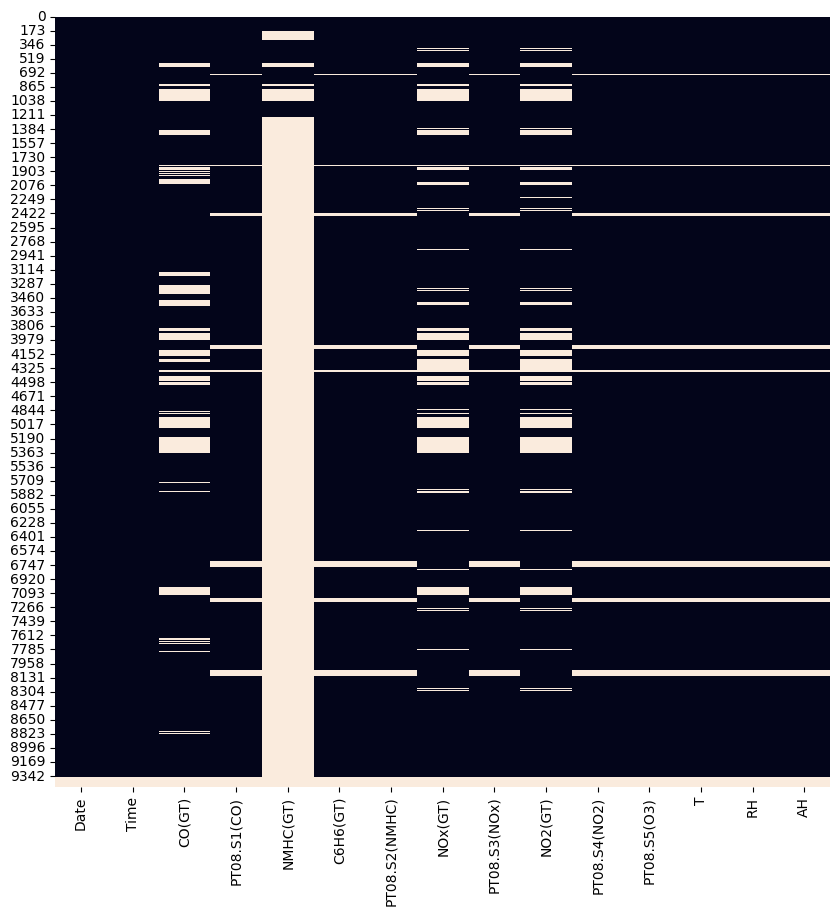

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna(),cbar=False)
plt.show()

In [10]:
samples_large_omissions = []
for i in range(len(df)):
    val = df.loc[i,:].isna().sum()
    if val > 0.3*len(df.columns) :
        samples_large_omissions.append(i)
print("Data Samples with more than 30% missing values (around 4 columns):",len(samples_large_omissions)," ",len(samples_large_omissions)/len(df))
print("\n")

samples_large_omissions = []
for i in range(len(df)):
    val = df.loc[i,:].isna().sum()
    if val > 0.9*len(df.columns) :
        samples_large_omissions.append(i)
print("Data Samples with more than 90% missing values (all columns):",samples_large_omissions)

Data Samples with more than 30% missing values (around 4 columns): 480   0.05068102629078239


Data Samples with more than 90% missing values (all columns): [9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470]


In [11]:
features_large_omissions = []
for i,col in enumerate(df.columns):
    val = df.loc[:,col].isna().sum()
    if val > 0.1*len(df) :
        features_large_omissions.append(col)
        print("{}) {} : {} {}".format(i,col,val,val/len(df)))
print("Features with more than 10% missing values:",features_large_omissions)

2) CO(GT) : 1797 0.18973709217611656
4) NMHC(GT) : 8557 0.9034948791046352
7) NOx(GT) : 1753 0.18509133143279485
9) NO2(GT) : 1756 0.18540808784711224
Features with more than 10% missing values: ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']


<p>Now based on the above analysis we can make following points :-</p>
<ul>
<li>Roughly around 5% of data samples have atleast 4 columns missing.&nbsp;</li>
<li>There are 4 feature columns for which roughly more 20% data samples are missing. We can use appropriate imputer for these feature columns.</li>
<li>There is one feature column <strong>"NMHC(GT)"&nbsp;</strong>for which almost all feature data is missing and so we will drop this column.</li>
<li>There are some data samples which have all feature columns missing that is the whole row is just empty and so we will drop these data samples.</li>
</ul>

In [12]:
df = df.drop(samples_large_omissions,axis=0)

df = df.drop(["NMHC(GT)"],axis=1)
num_cols = num_cols.drop("NMHC(GT)")

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   C6H6(GT)       8991 non-null   float64
 5   PT08.S2(NMHC)  8991 non-null   float64
 6   NOx(GT)        7718 non-null   float64
 7   PT08.S3(NOx)   8991 non-null   float64
 8   NO2(GT)        7715 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  T              8991 non-null   float64
 12  RH             8991 non-null   float64
 13  AH             8991 non-null   float64
dtypes: float64(12), object(2)
memory usage: 1023.6+ KB


None

Date      Time  CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00     2.6       1360.0      11.9         1046.0   
1  10/03/2004  19.00.00     2.0       1292.0       9.4          955.0   
2  10/03/2004  20.00.00     2.2       1402.0       9.0          939.0   
3  10/03/2004  21.00.00     2.2       1376.0       9.2          948.0   
4  10/03/2004  22.00.00     1.6       1272.0       6.5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9   
1    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7   
2    131.0        1140.0    114.0        1555.0       1074.0  11.9  54.0   
3    172.0        1092.0    122.0        1584.0       1203.0  11.0  60.0   
4    131.0        1205.0    116.0        1490.0       1110.0  11.2  59.6   

       AH  
0  0.7578  
1  0.7255  
2  0.7502  
3  0.7867  
4  0.7888

<h4>Numerical Analysis</h4>

In [145]:
display(df[num_cols].describe())

CO(GT)  PT08.S1(CO)     C6H6(GT)  PT08.S2(NMHC)      NOx(GT)  \
count  7674.000000  8991.000000  8991.000000    8991.000000  7718.000000   
mean      2.152750  1099.833166    10.083105     939.153376   246.896735   
std       1.453252   217.080037     7.449820     266.831429   212.979168   
min       0.100000   647.000000     0.100000     383.000000     2.000000   
25%       1.100000   937.000000     4.400000     734.500000    98.000000   
50%       1.800000  1063.000000     8.200000     909.000000   180.000000   
75%       2.900000  1231.000000    14.000000    1116.000000   326.000000   
max      11.900000  2040.000000    63.700000    2214.000000  1479.000000   

       PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)            T  \
count   8991.000000  7715.000000   8991.000000  8991.000000  8991.000000   
mean     835.493605   113.091251   1456.264598  1022.906128    18.317829   
std      256.817320    48.370108    346.206794   398.484288     8.832116   
min      322.000000     2.000000    551.000000   221.000000    -1.900000   
25%      658.000000    78.000000   1227.000000   731.500000    11.800000   
50%      806.000000   109.000000   1463.000000   963.000000    17.800000   
75%      969.500000   142.000000   1674.000000  1273.500000    24.400000   
max     2683.000000   340.000000   2775.000000  2523.000000    44.600000   

                RH           AH  
count  8991.000000  8991.000000  
mean     49.234201     1.025530  
std      17.316892     0.403813  
min       9.200000     0.184700  
25%      35.800000     0.736800  
50%      49.600000     0.995400  
75%      62.500000     1.313700  
max      88.700000     2.231000

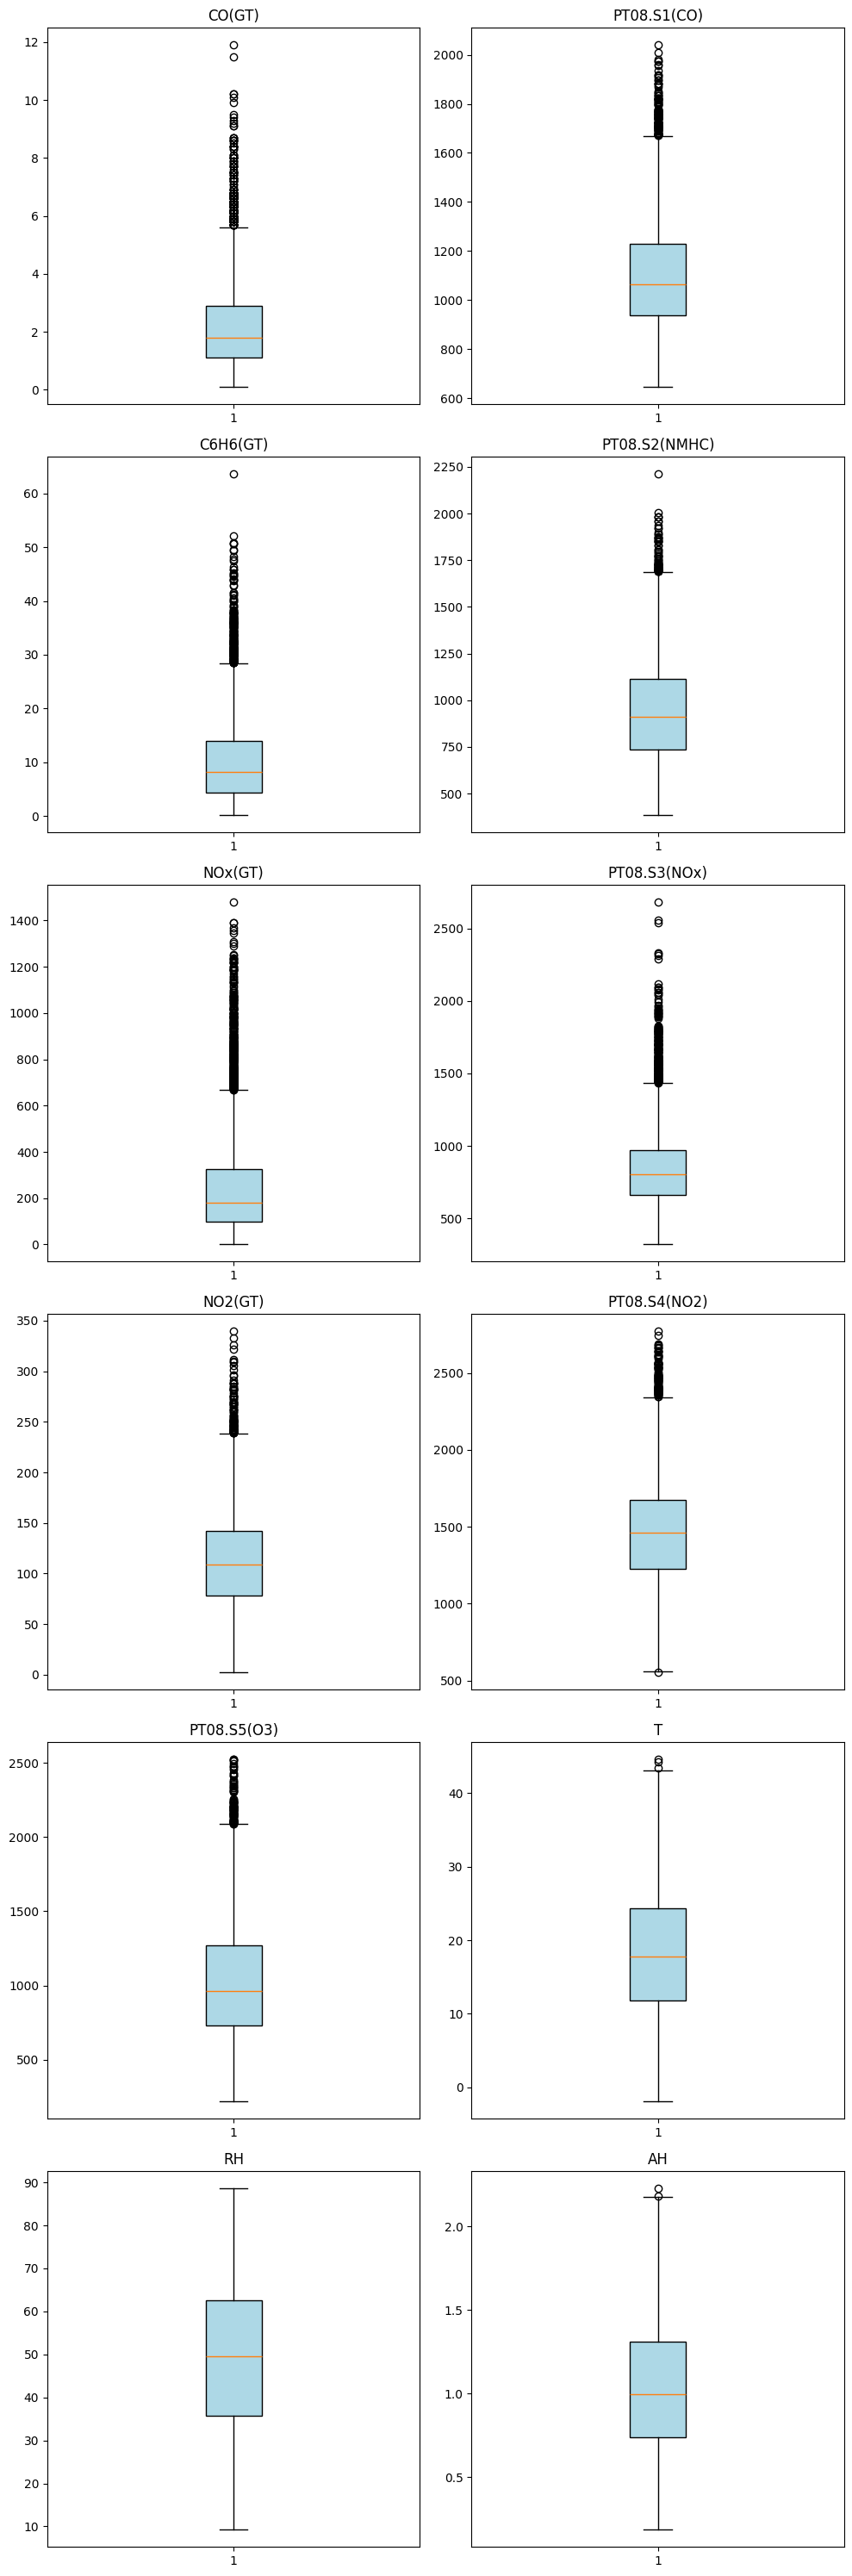

In [147]:
fig, axes = plt.subplots(6, 2, figsize=(2 * 5, 6 * 5))
axes = axes.ravel()
for i,col in enumerate(num_cols):
    axes[i].boxplot(df[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
display(df[num_cols].skew())

CO(GT)           1.369753
PT08.S1(CO)      0.755907
C6H6(GT)         1.361532
PT08.S2(NMHC)    0.561566
NOx(GT)          1.715781
PT08.S3(NOx)     1.101729
NO2(GT)          0.621714
PT08.S4(NO2)     0.205389
PT08.S5(O3)      0.627864
T                0.309357
RH              -0.037928
AH               0.251388
dtype: float64

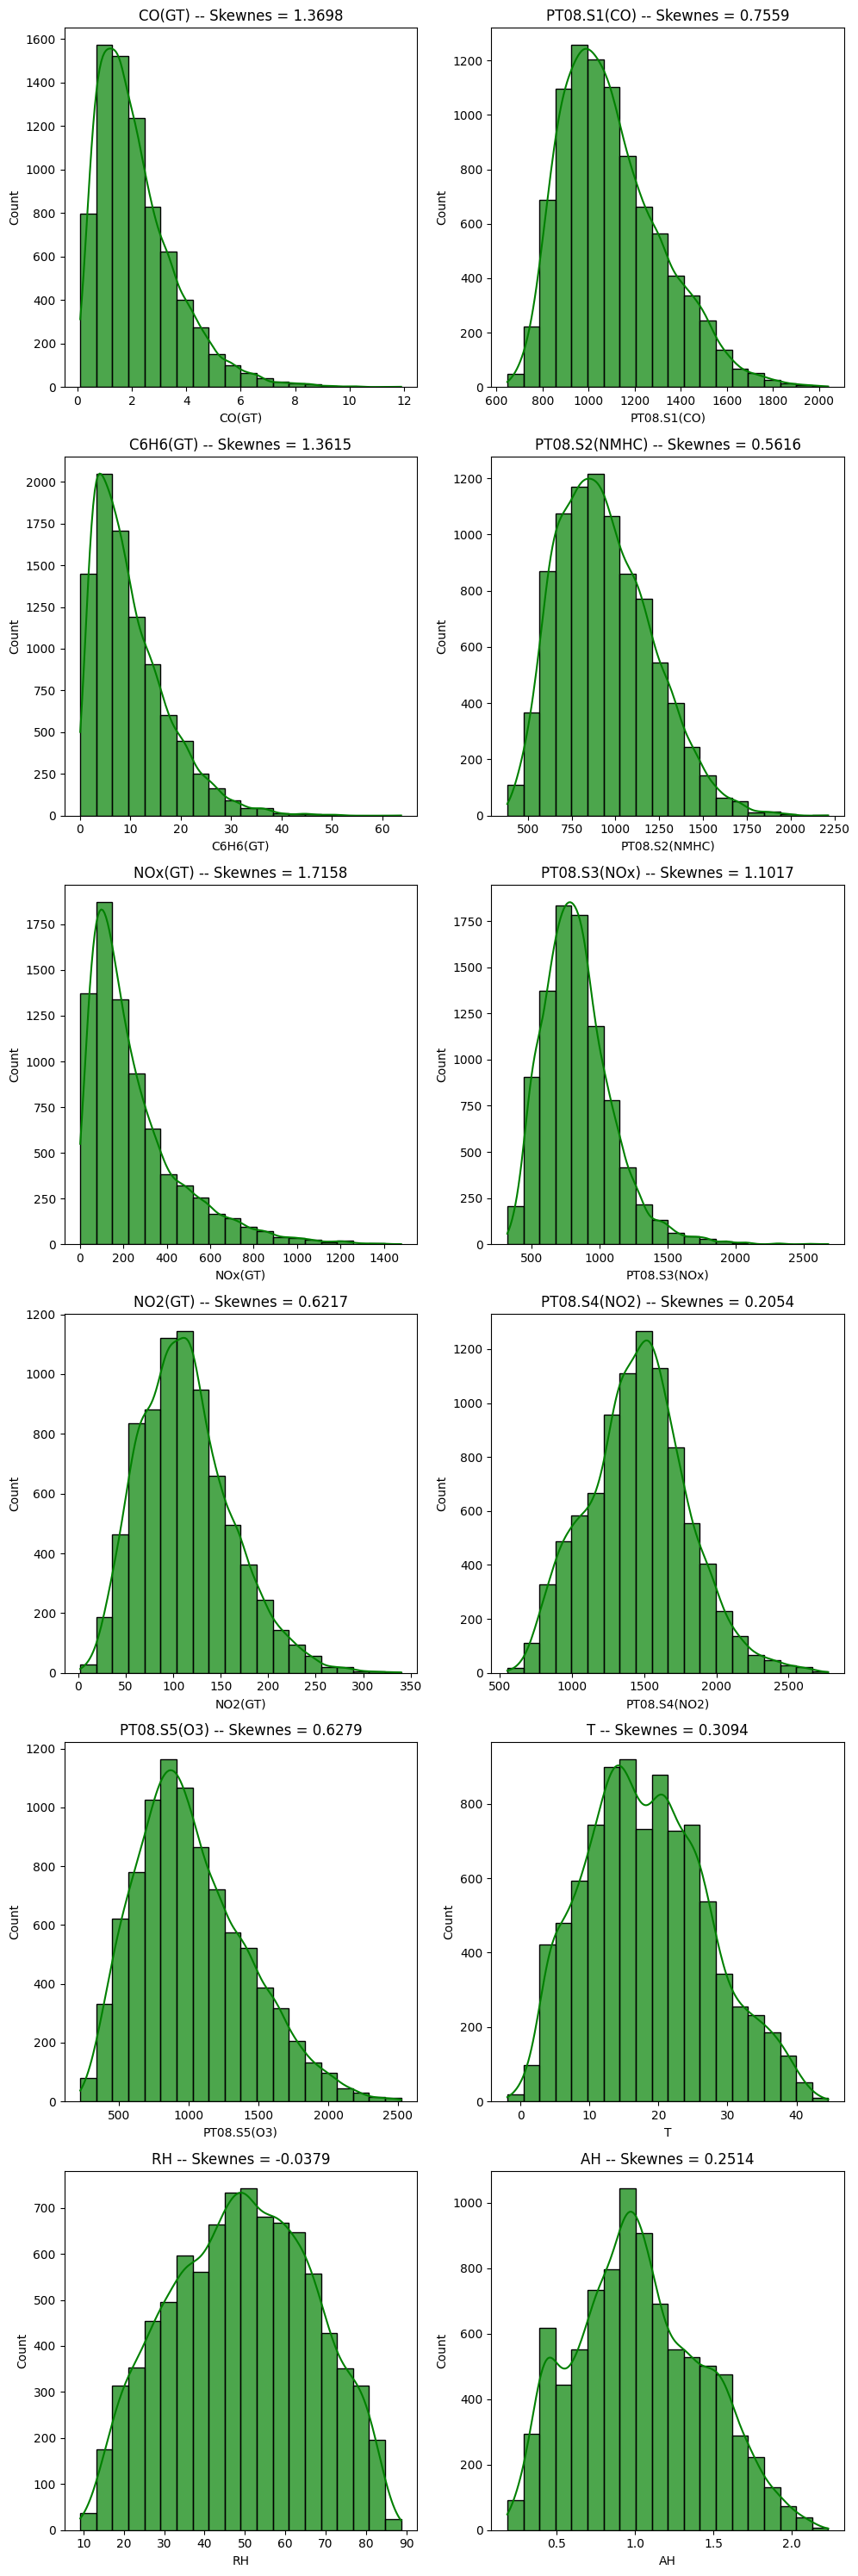

In [167]:
fig, axes = plt.subplots(6, 2, figsize=(2 * 5, 6 * 5))
axes = axes.ravel()
for i,col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, bins=20, color='green', alpha=0.7, edgecolor='black', ax=axes[i])
    axes[i].set_title("{} -- Skewnes = {}".format(col,round(df[col].skew(),4)))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

count    104026.000000
mean        496.380532
std         563.696177
min          -1.900000
25%          13.200000
50%         135.000000
75%         948.000000
max        2775.000000
dtype: float64


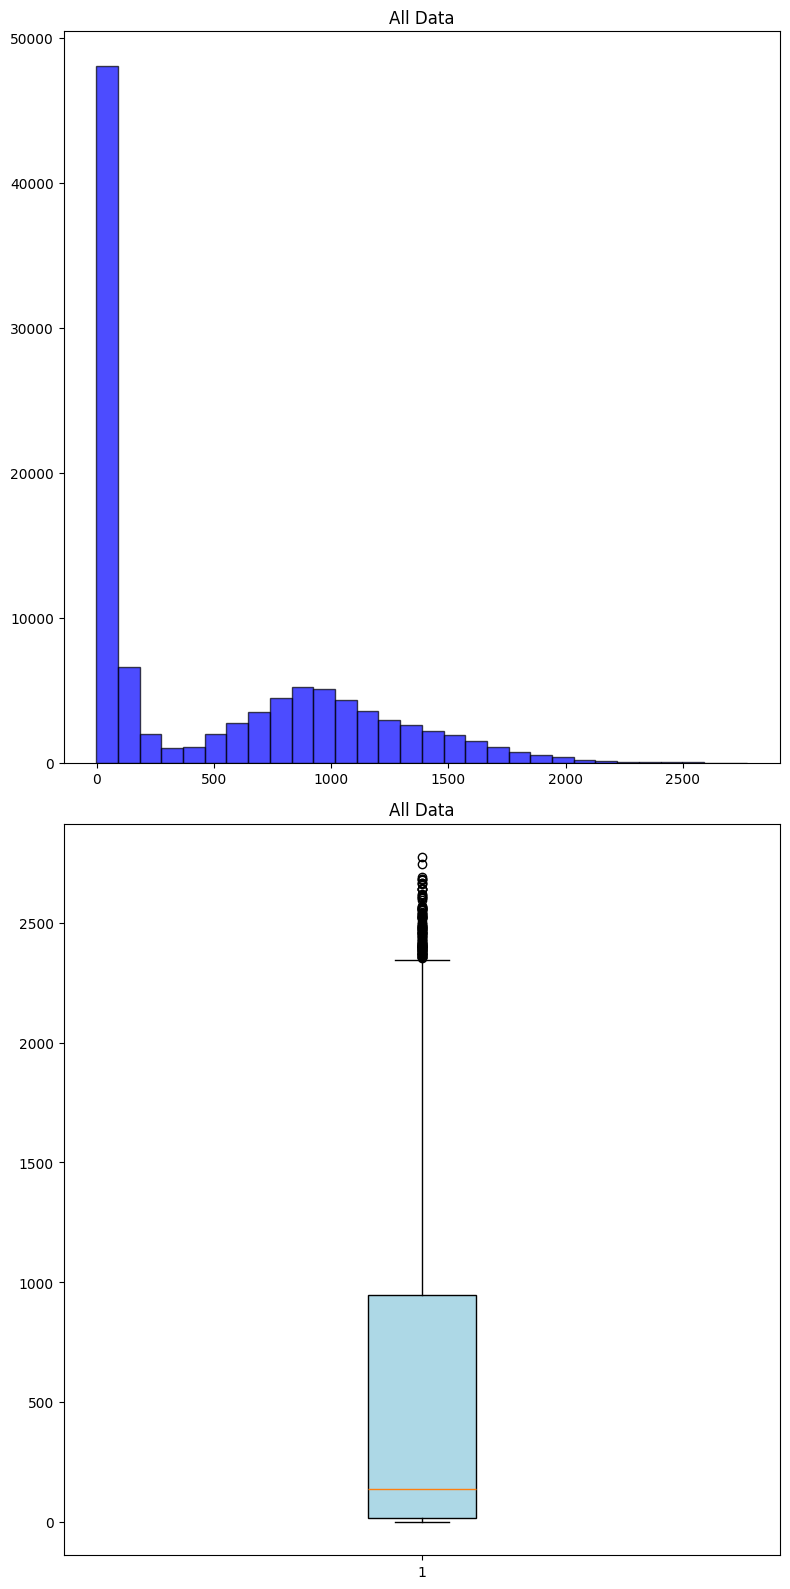

In [152]:
arr = []
for col in num_cols:
    arr += df[col].dropna().to_list()

print(pd.Series(arr).describe())

fig, axes = plt.subplots(2,1,figsize=(1*8, 2*8))

axes[0].hist(arr, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title("All Data")

axes[1].boxplot(arr, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1].set_title("All Data")

plt.tight_layout()
plt.show()

<p>Now based on the above analysis we can make following points :-</p>
<ul>
<li>From the <strong>"box-plots"</strong>, we can observe that, some of the feature columns have large number of outliers.</li>
<li>Upon examining the <strong>skewness, kde plots and histogram,</strong> we can conclude that the feature columns <strong>CO(GT), PT08.S1(CO) , C6H6(GT), NOx(GT), </strong>and<strong> PT08.S3(NOx), </strong>are highly positively skewed. We will use appropriate transformation to remove the skewness from these feature columns. <strong>[Refer bibliography]</strong></li>
<li>Overall, the whole dataset does not exhibit any particular kind of trend.</li>
</ul>
<p><strong>Bibliography : </strong><a href="https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists/">Removing skewness</a></p>

<h4>Correlation Analysis</h4>

In [170]:
def get_top_abs_correlations(data=df,n=5):
    corr = df[num_cols].corr().abs().unstack()
    pairs_to_drop = set()
    for i in range(len(num_cols)):
        for j in range(0,i+1):
            pairs_to_drop.add((num_cols[i],num_cols[j]))
    corr = corr.drop(labels=pairs_to_drop).sort_values(ascending=False)
    return corr[:n]

print(get_top_abs_correlations(df,np.square(len(num_cols))))

C6H6(GT)      PT08.S2(NMHC)    0.981950
CO(GT)        C6H6(GT)         0.931078
              PT08.S2(NMHC)    0.915514
PT08.S1(CO)   PT08.S5(O3)      0.899324
              PT08.S2(NMHC)    0.892964
                                 ...   
              T                0.048627
CO(GT)        AH               0.048556
PT08.S4(NO2)  RH               0.032188
PT08.S5(O3)   T                0.027172
CO(GT)        T                0.022109
Length: 66, dtype: float64


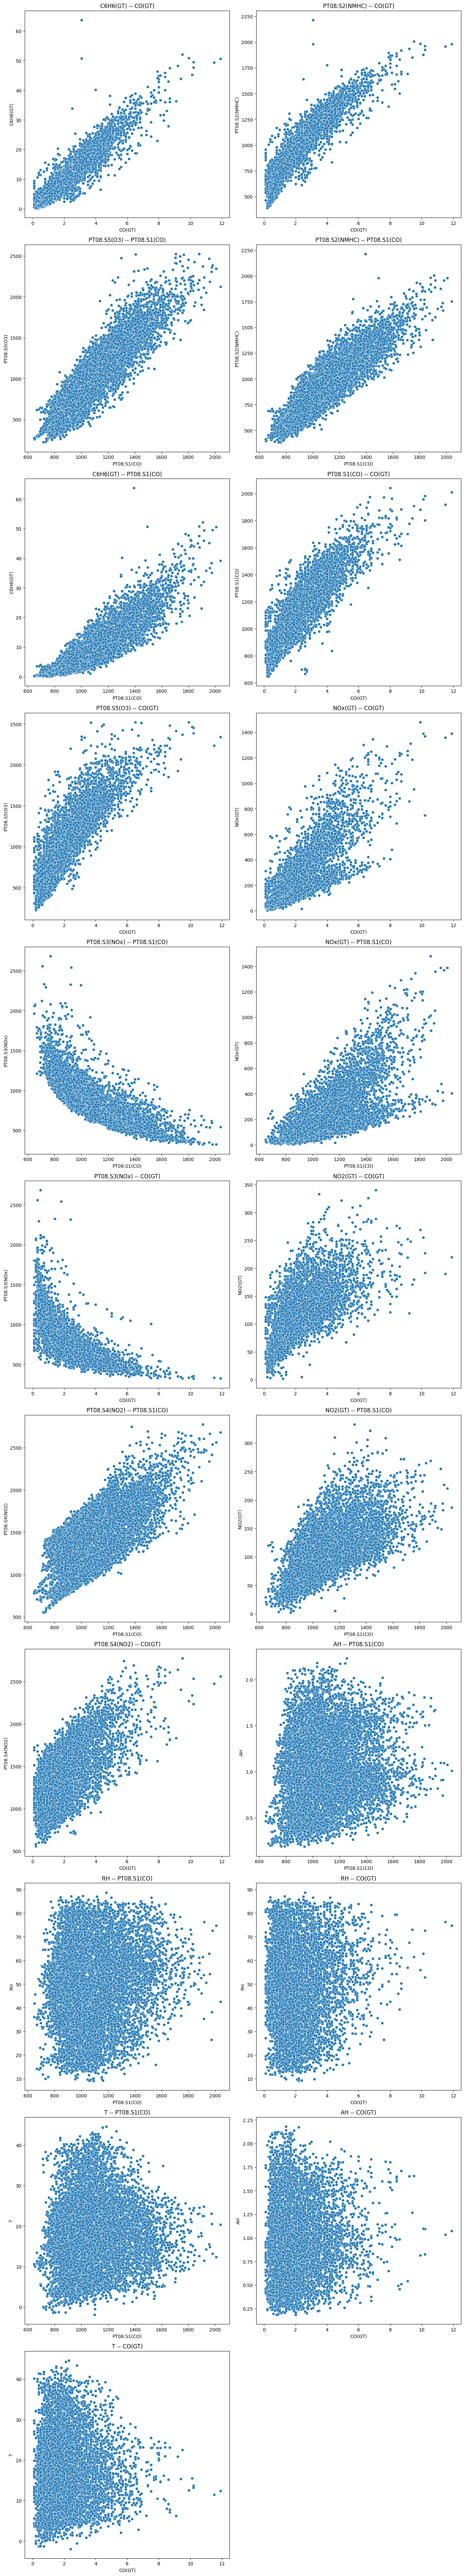

In [185]:
all_corr_count = np.square(len(num_cols))
corr = get_top_abs_correlations(df,all_corr_count)

corr_idx = []
for i,val in enumerate(corr.index):
    x = val[0]
    y = val[1]
    if x in target_class or y in target_class:
        corr_idx.append(i)

corr = corr[corr.index[corr_idx]]
n = len(corr)

fig, axes = plt.subplots(n, 2, figsize=(2 * 7, n * 7))

axes = axes.ravel()

for i,val in enumerate(corr.index):
    x = val[0]
    y = val[1]
    sns.scatterplot(x=df[x],y=df[y],ax=axes[i]);
    axes[i].set_title(y+" -- "+x)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

count    66.000000
mean      0.487140
std       0.318659
min       0.022109
25%       0.160013
50%       0.622058
75%       0.765076
max       0.981950
dtype: float64


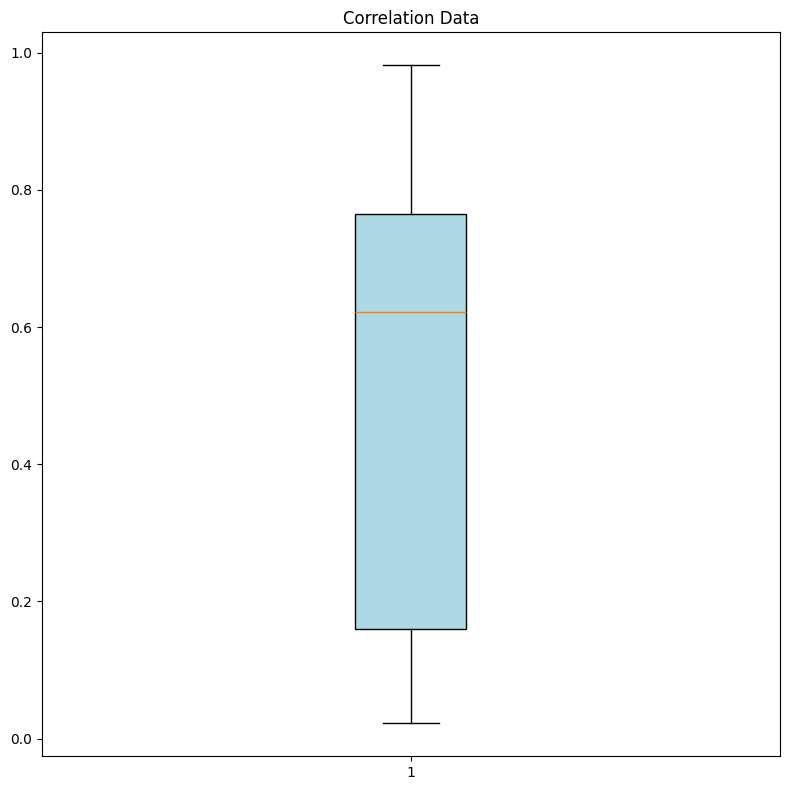

No of pair of features with correlation > 0.8 are: 10
No of pair of features with correlation > 0.5 are: 38


In [177]:
all_corr_count = np.square(len(num_cols))
corr = get_top_abs_correlations(df,all_corr_count)

print(corr.describe())

fig, axes = plt.subplots(figsize=(8, 8))

axes.boxplot(corr, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes.set_title("Correlation Data")

plt.tight_layout()
plt.show()

print("No of pair of features with correlation > 0.8 are: {}".format(sum(corr>0.8)))
print("No of pair of features with correlation > 0.5 are: {}".format(sum(corr>0.5)))

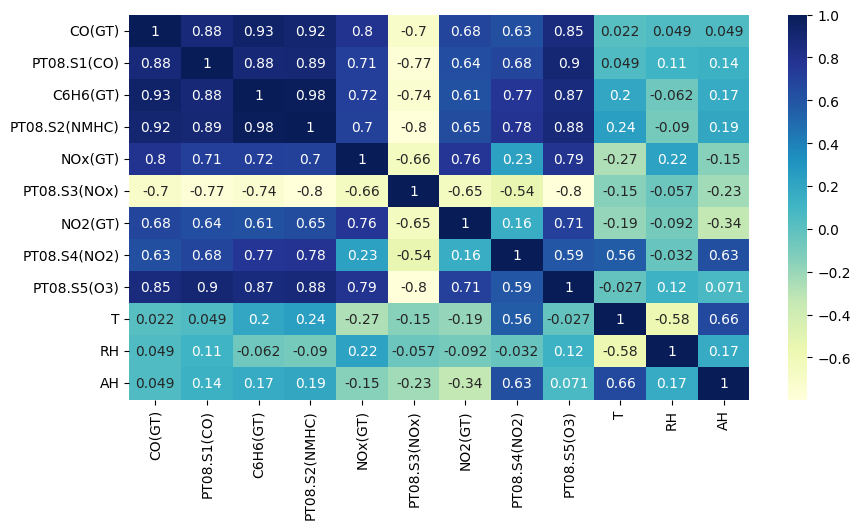

In [179]:
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols].corr(),cmap='YlGnBu',annot=True)
plt.show()

In [215]:
X = df[num_cols].copy()

X = X.dropna()

X = PowerTransformer(method="yeo-johnson").fit_transform(X)

X = pd.DataFrame(X,columns=num_cols)

X = X.drop(target_class[0],axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)
print("\n")

X = df[num_cols].copy()

X = X.dropna()

X = PowerTransformer(method="yeo-johnson").fit_transform(X)

X = pd.DataFrame(X,columns=num_cols)

X = X.drop(target_class[1],axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

     VIF Factor       features
0      8.386107    PT08.S1(CO)
1   7136.016943       C6H6(GT)
2   7324.052054  PT08.S2(NMHC)
3     12.771434        NOx(GT)
4      7.527909   PT08.S3(NOx)
5      5.531435        NO2(GT)
6     21.271132   PT08.S4(NO2)
7      8.337054    PT08.S5(O3)
8     20.955739              T
9     12.457981             RH
10    17.925195             AH


     VIF Factor       features
0      8.879129         CO(GT)
1   7088.586702       C6H6(GT)
2   7254.283792  PT08.S2(NMHC)
3     13.487843        NOx(GT)
4      6.936788   PT08.S3(NOx)
5      5.400727        NO2(GT)
6     19.953721   PT08.S4(NO2)
7      7.771054    PT08.S5(O3)
8     20.943469              T
9     12.032152             RH
10    17.091512             AH


<p>Now based on the above analysis we can make following points :-</p>
<ul>
<li>Based on the scatter plots, we can conclude that there is not enough evidence that our target feature variables, "<strong>CO(GT)</strong>" and "<strong>PT08.S1(CO)</strong>", are strongly correlated to most of the other feature variables.</li>
<li>Upong conducting the <strong>"Variation Inflation Factor"</strong> test, we can observe that the feature columns, <strong>"C6H6(GT)"</strong> and <strong>"PT08.S2(NMHC)",</strong> have very high VIF values indicating<strong> high multicollinearity</strong> in the data.</li>
<li>Techniques like <strong>"lasso"</strong> and <strong>"ridge"</strong> regression can be used to address this multicollinearity and penalize the regressors which causes the same.<strong>[Refer Bibliography]</strong></li>
<li>For overall data, examining the <strong>"box-plots"</strong> and <strong>"heatmap"</strong>, we can conclude that there is evidence of strong correlation between the <strong>"pollutant feature columns".</strong></li>
</ul>
<p><strong>Bibliography: <a href="https://medium.com/@satyarepala/tackling-multicollinearity-understanding-variance-inflation-factor-vif-and-mitigation-techniques-2521ebf024b6">Addressing multicollinearity</a></strong></p>

<h4>Temporal Analysis</h4>

In [14]:
timestamp = (df["Date"]) + " " + (df["Time"])
timestamp = timestamp.apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H.%M.%S"))

month = timestamp.dt.month_name()
day = timestamp.dt.day_name()
hour = timestamp.dt.hour

df_temp = pd.DataFrame({
    'DateTime': timestamp,
    'Month': month,
    'Day': day,
    'Hour': hour
})
df = pd.concat([df_temp, df], axis=1)

df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

df = df.drop(["Time"],axis=1)

display(df.info())
print("\n")
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   Month          9357 non-null   object        
 2   Day            9357 non-null   object        
 3   Hour           9357 non-null   int32         
 4   CO(GT)         7674 non-null   float64       
 5   PT08.S1(CO)    8991 non-null   float64       
 6   C6H6(GT)       8991 non-null   float64       
 7   PT08.S2(NMHC)  8991 non-null   float64       
 8   NOx(GT)        7718 non-null   float64       
 9   PT08.S3(NOx)   8991 non-null   float64       
 10  NO2(GT)        7715 non-null   float64       
 11  PT08.S4(NO2)   8991 non-null   float64       
 12  PT08.S5(O3)    8991 non-null   float64       
 13  T              8991 non-null   float64       
 14  RH             8991 non-null   float64       
 15  AH             8991 n

None

DateTime  Month        Day  Hour  CO(GT)  PT08.S1(CO)  C6H6(GT)  \
0 2004-03-10 18:00:00  March  Wednesday    18     2.6       1360.0      11.9   
1 2004-03-10 19:00:00  March  Wednesday    19     2.0       1292.0       9.4   
2 2004-03-10 20:00:00  March  Wednesday    20     2.2       1402.0       9.0   
3 2004-03-10 21:00:00  March  Wednesday    21     2.2       1376.0       9.2   
4 2004-03-10 22:00:00  March  Wednesday    22     1.6       1272.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [256]:
month_df_list = []
day_df_list   = []
hour_df_list  = []

months = ['January','February','March', 'April', 'May','June', 
          'July', 'August', 'September', 'October', 'November', 'December']

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for month in months:
    temp_df = df.loc[(df["Month"] == month)]
    month_df_list.append(temp_df)

for day in days:
    temp_df = df.loc[(df["Day"] == day)]
    day_df_list.append(temp_df)

for hour in range(24):
    temp_df = df.loc[(df["Hour"] == hour)]
    hour_df_list.append(temp_df)

def df_time_plotter(df_list, time_unit, y_col):
    if time_unit == 'M':
        nRows = 3
        nCols = 4
        n_iter = len(months)
    elif time_unit == 'D':
        nRows = 2
        nCols = 4
        n_iter = len(days)
    elif time_unit == 'H':
        nRows = 4
        nCols = 6
        n_iter = 24
        
    fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize = (40,30))
    axs = axs.ravel()
    for i in range(n_iter):
        data = df_list[i]
        ax = axs[i]
        data.plot(kind ='scatter', x = 'DateTime', y= y_col , ax = ax, fontsize = 24)
        ax.set_ylabel('Pollutant Concentration',fontsize=30)
        ax.set_xlabel('')
        if time_unit == 'M':
            ax.set_title(y_col + ' ' + months[i],  size=40) # Title
        elif time_unit == 'D':
            ax.set_title(y_col + ' ' + days[i],  size=40) # Title
        else:
             ax.set_title(y_col + ' ' + str(i),  size=40) # Title
        ax.tick_params(labelrotation=60)
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)
    plt.show()

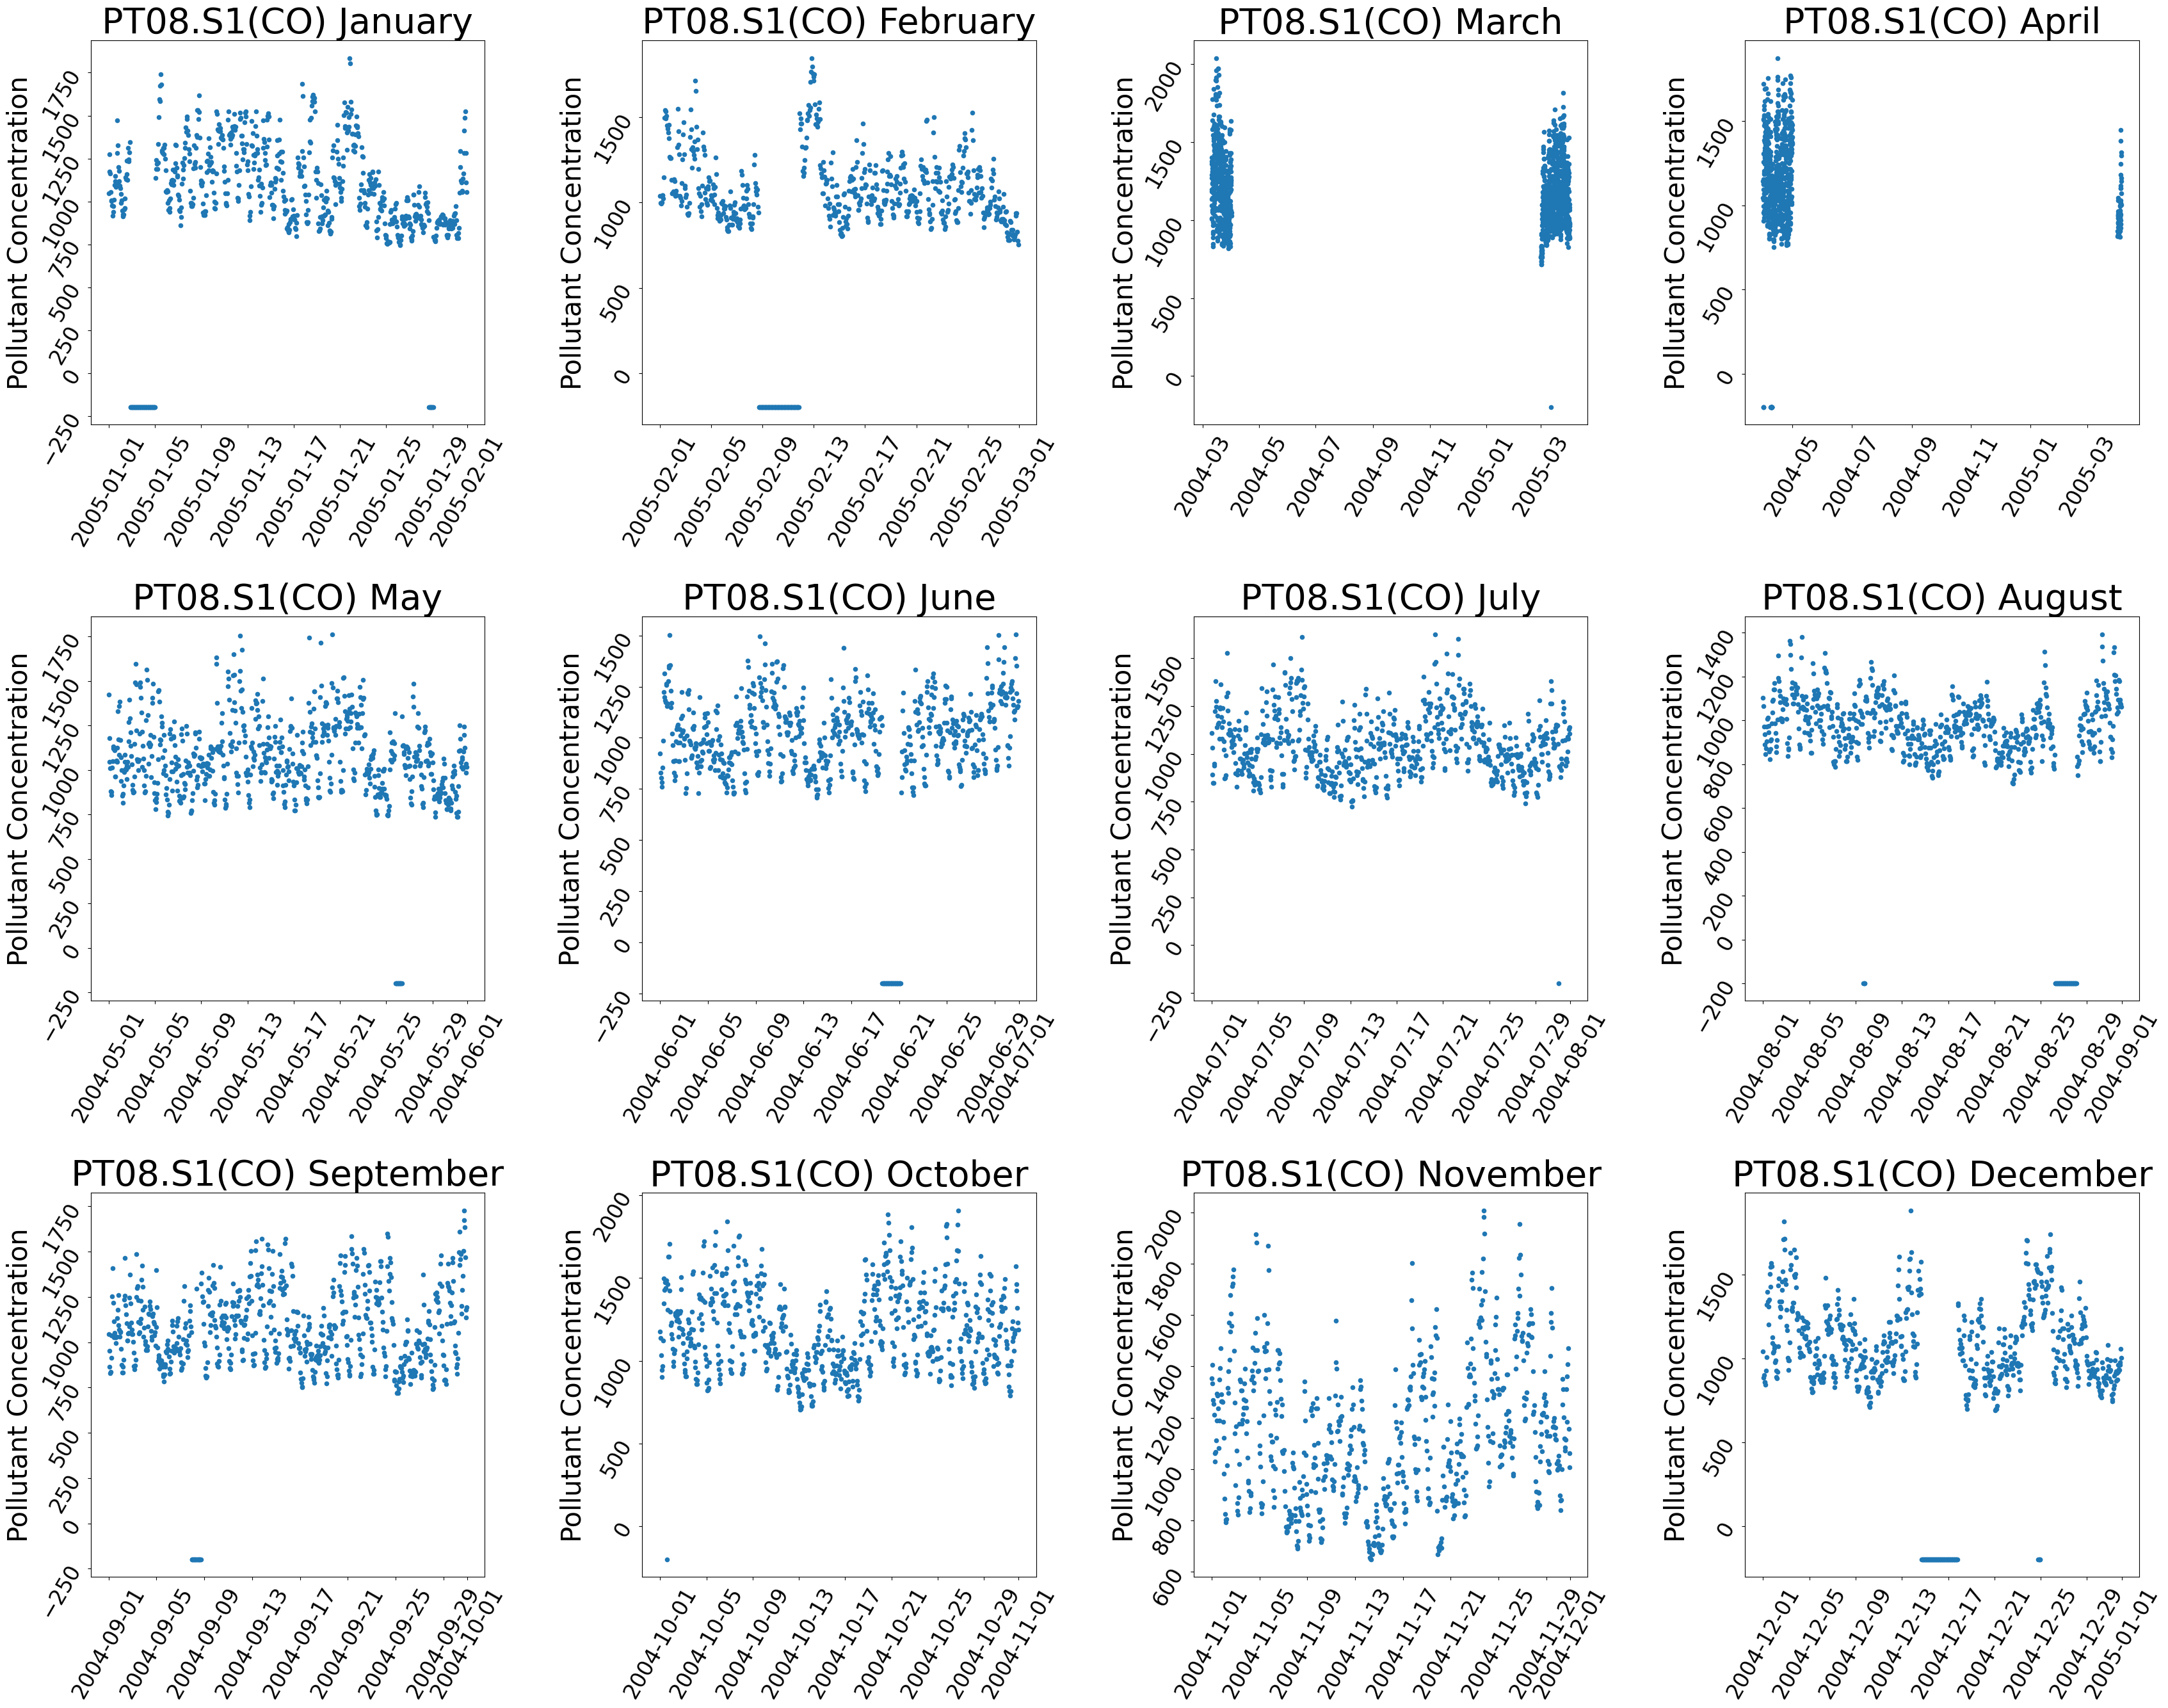

In [258]:
df_time_plotter(month_df_list,"M","PT08.S1(CO)")

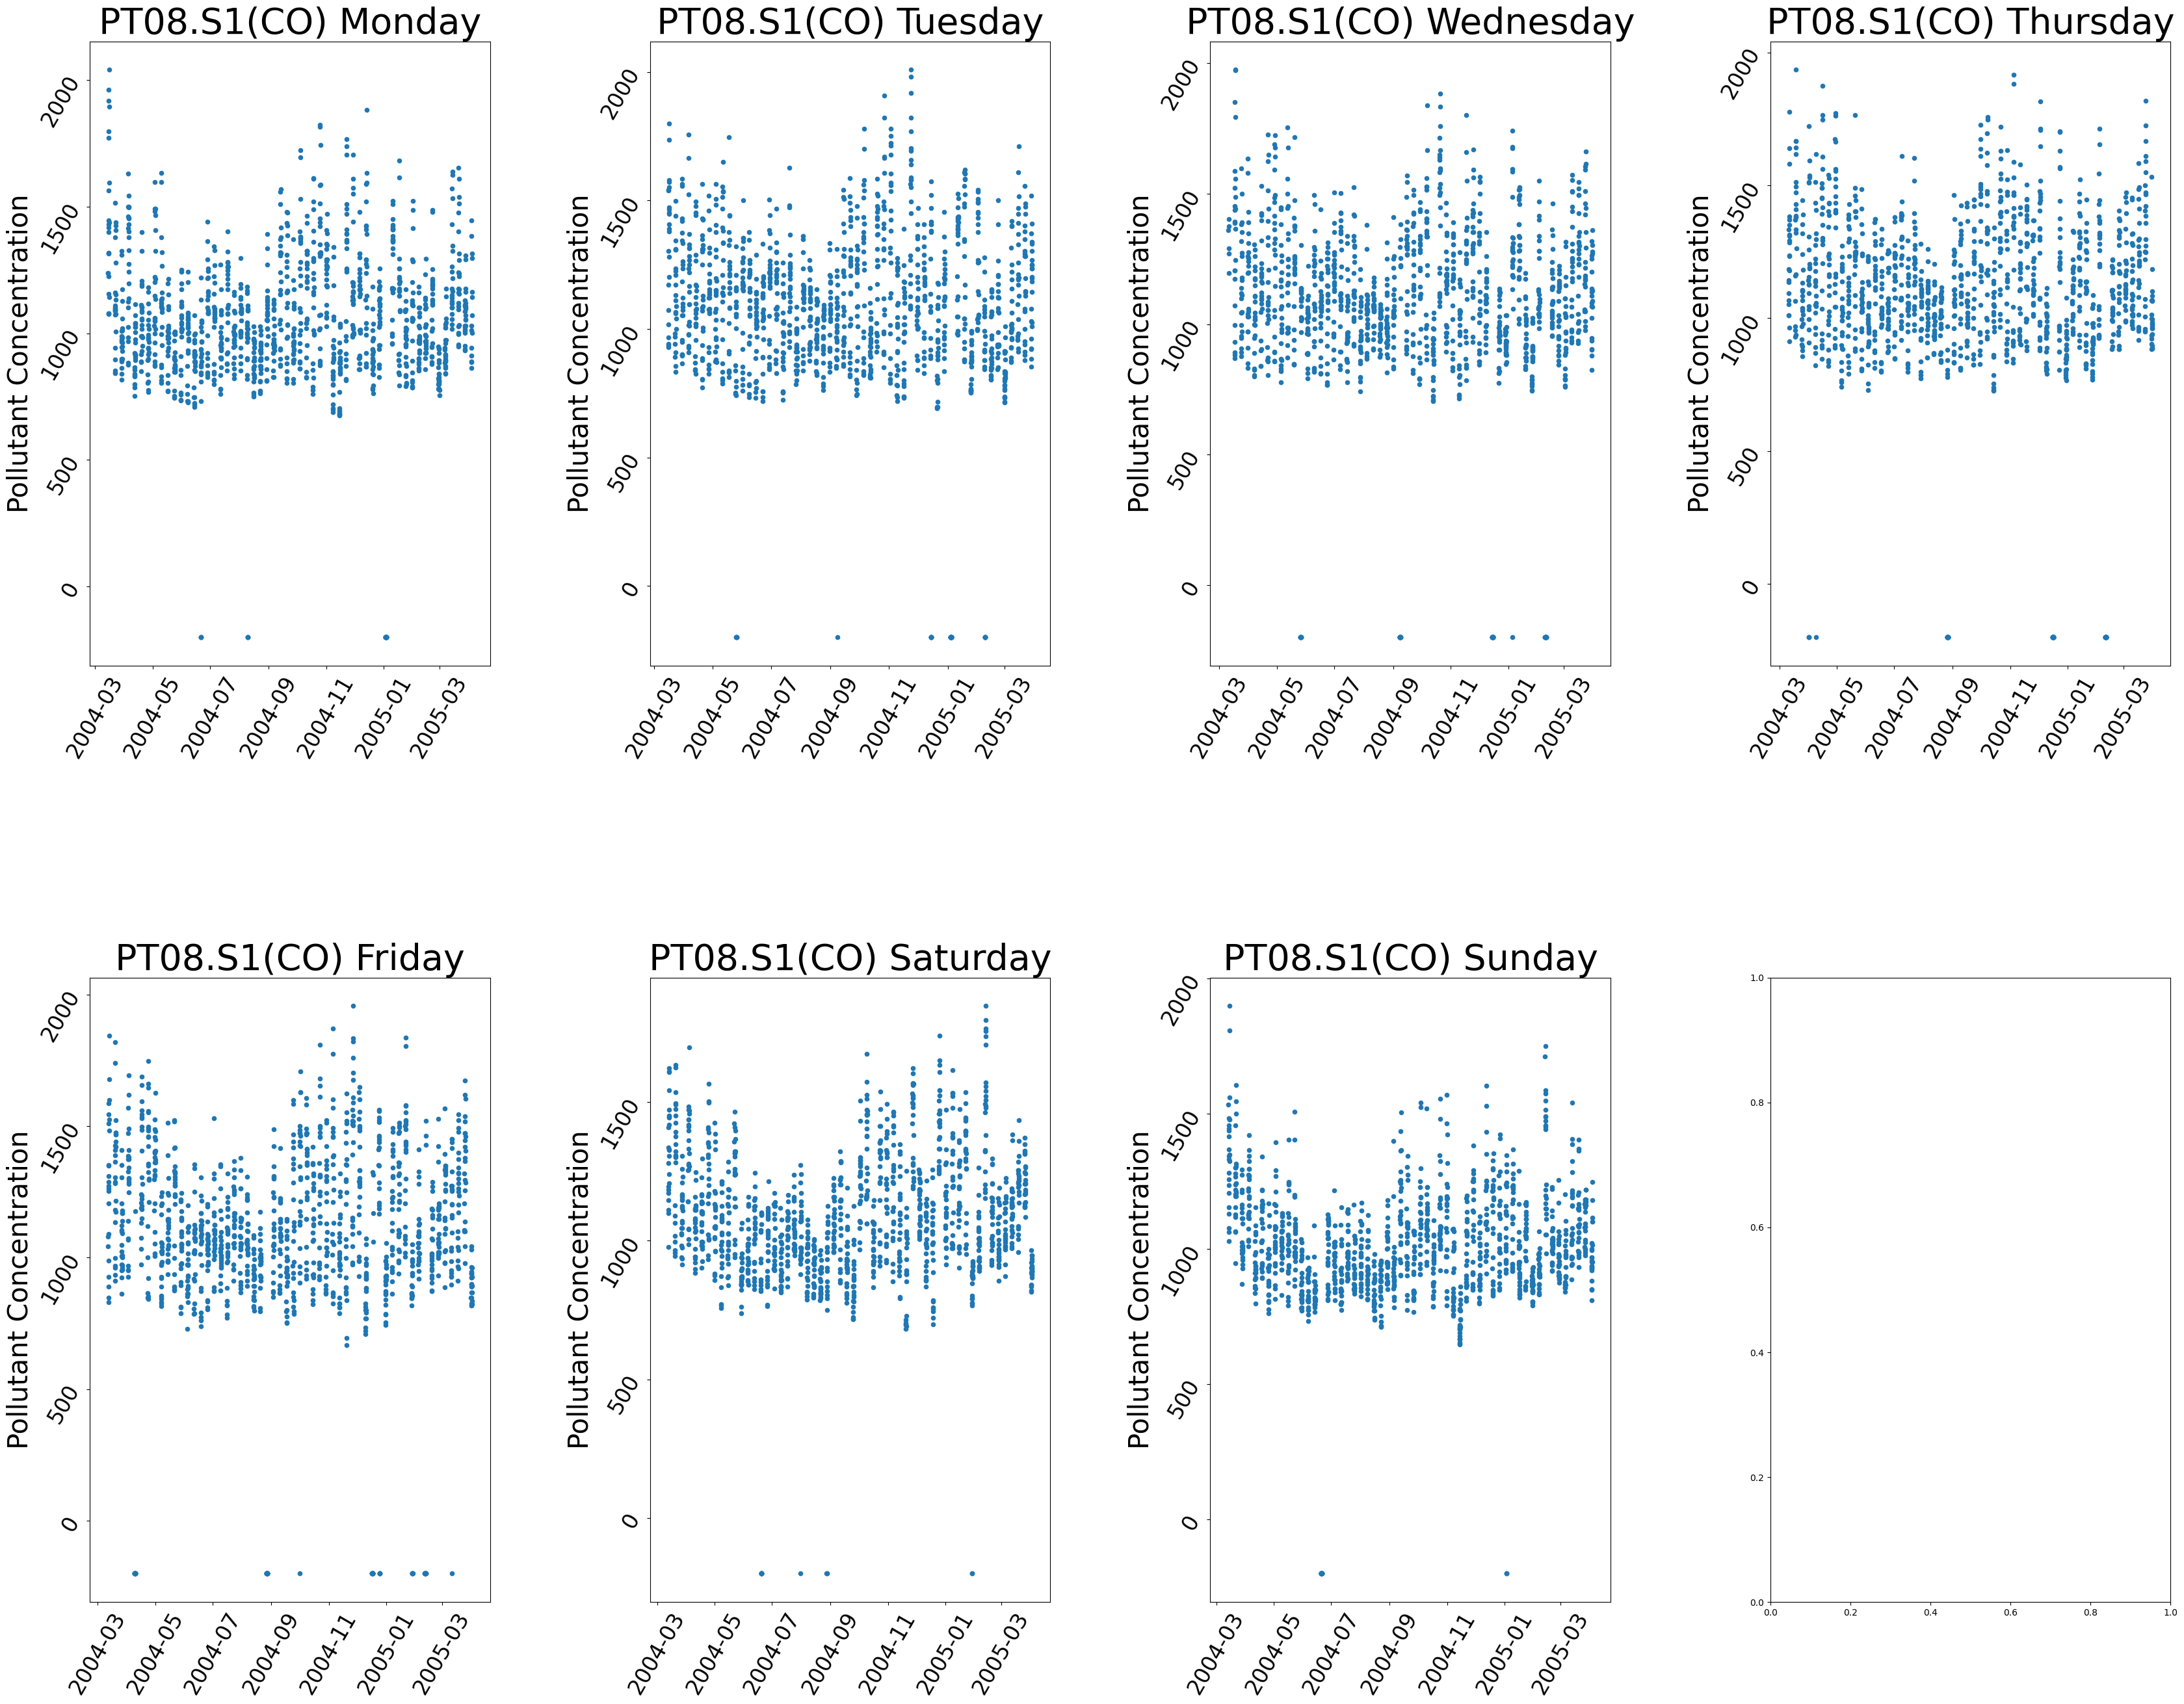

In [259]:
df_time_plotter(day_df_list,"D","PT08.S1(CO)")

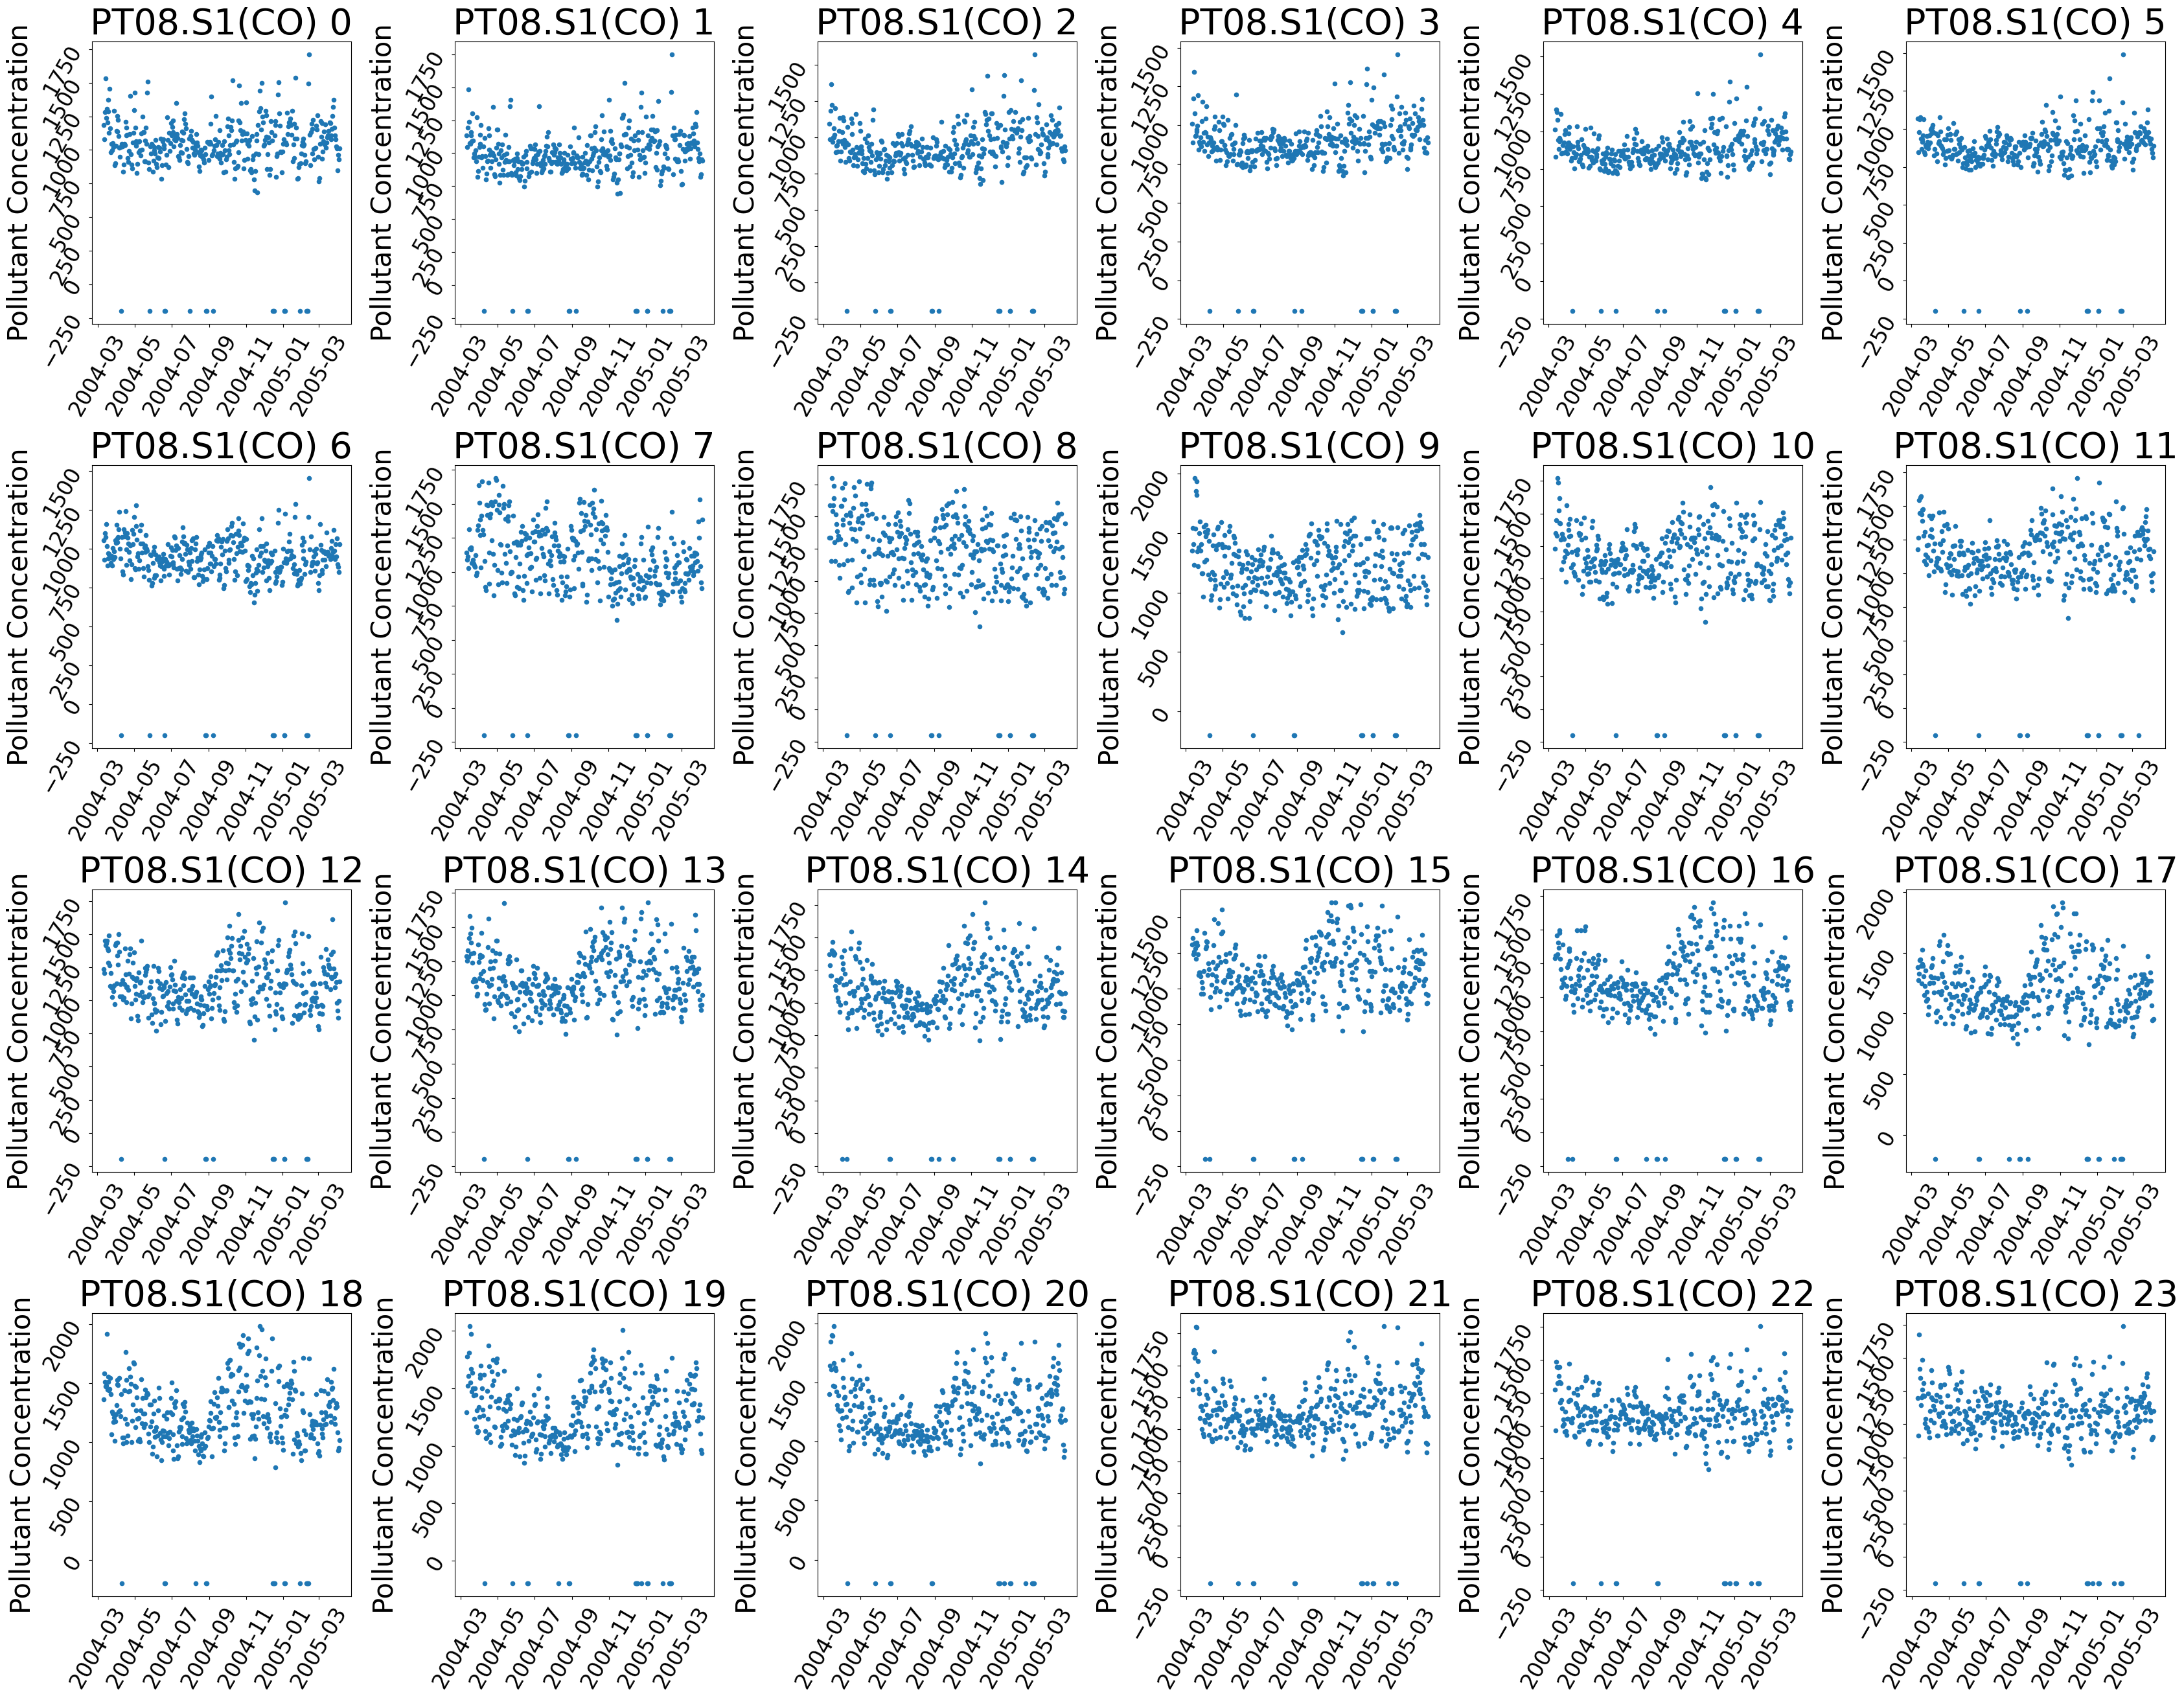

In [260]:
df_time_plotter(hour_df_list,"H","PT08.S1(CO)")

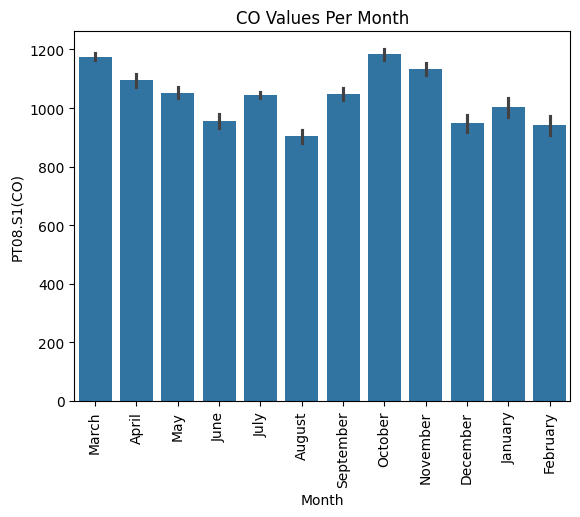

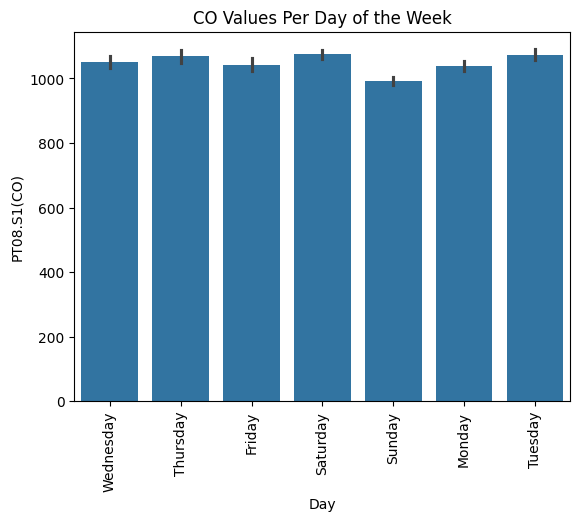

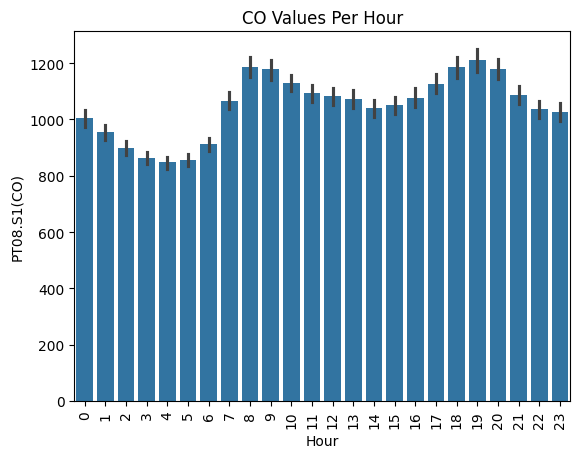

In [262]:
sns.barplot(x = 'Month', y = 'PT08.S1(CO)', data = df)
plt.title('CO Values Per Month')
plt.xticks(rotation=90)
plt.show()

sns.barplot(x = 'Day', y = 'PT08.S1(CO)', data = df)
plt.title('CO Values Per Day of the Week')
plt.xticks(rotation=90)
plt.show()

sns.barplot(x = 'Hour', y = 'PT08.S1(CO)', data = df)
plt.title('CO Values Per Hour')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

In [18]:
features_drop = df.columns.drop(num_cols)

print("Taget feature is : {}".format(target_class))
print("\n")

print("Features to drop are:-")
print(features_drop)
print("\n")

print("Numerical Columns are:-")
print(num_cols)

Taget feature is : Index(['CO(GT)', 'PT08.S1(CO)'], dtype='object')


Features to drop are:-
Index(['DateTime', 'Month', 'Day', 'Hour'], dtype='object')


Numerical Columns are:-
Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')


In [70]:
class FeatureDrop(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X = X.drop(self.features,axis=1)
        return X

drop_feat = FeatureDrop(features_drop)
mean_impute = SimpleImputer(strategy="mean")
std_scaler = StandardScaler()
skew_scale = PowerTransformer(method="yeo-johnson")

<h4> Train Test Split </h4>

In [23]:
df_train, df_test = train_test_split(df,stratify=df["Day"],test_size=0.2, random_state=42)

print("Length of df_train is : {}".format(len(df_train)))
print(df_train["Day"].value_counts())
print("\n")

print("Length of df_test is : {}".format(len(df_test)))
print(df_test["Day"].value_counts())
print("\n")

Length of df_train is : 7485
Day
Sunday       1075
Saturday     1075
Thursday     1075
Friday       1075
Monday       1068
Wednesday    1061
Tuesday      1056
Name: count, dtype: int64


Length of df_test is : 1872
Day
Thursday     269
Friday       269
Saturday     269
Sunday       269
Monday       267
Wednesday    265
Tuesday      264
Name: count, dtype: int64




# Model Training and Evaluation

<p>Based on above all the analysis, we will use 3 kind of models to train and evaluate our data. These models are :-</p>
<ol>
<li><strong>Ridge regression&nbsp;</strong></li>
<li><strong>Lasso&nbsp;regression</strong></li>
<li><strong>ElasticNet regression</strong></li>
</ol>
<p>Now the model training plan would be similar for all the three models and is outlined below :-</p>
<ul>
<li><strong>model&nbsp;= {"Feature Drop", "Data Imputation", "Skew Balance", "Standard Normalization", "Parameter Tuning", "Training", "Evaluation" }</strong></li>
</ul>
<p>We will have <strong>two regression models</strong> for each for one of the target class feature columns.</p>

In [133]:
def evaluation(y_pred,y_test):
    r2 = r2_score(y_test, y_pred)
    mas = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    
    print("R2 score = ", r2_score(y_test, y_pred))
    print("\n")

    print("MAS = ", mean_absolute_error(y_test,y_pred))
    print("\n")

    print("MSE = ", mean_squared_error(y_test,y_pred))
    print("\n")

    return [r2, mas, mse]

all_scores = []

<h4> Ridge Regression </h4>

In [134]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

ridge_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(ridge_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(ridge_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha":np.linspace(0.01,0.1,20)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = Ridge(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': np.float64(0.1)}


Best r2 : 0.7376987991142344


Best param for ridge are:-
{'alpha': np.float64(0.1)}


Best neg_root_mean_squared_error : -0.5115858065595791




Ridge(alpha=0.1)

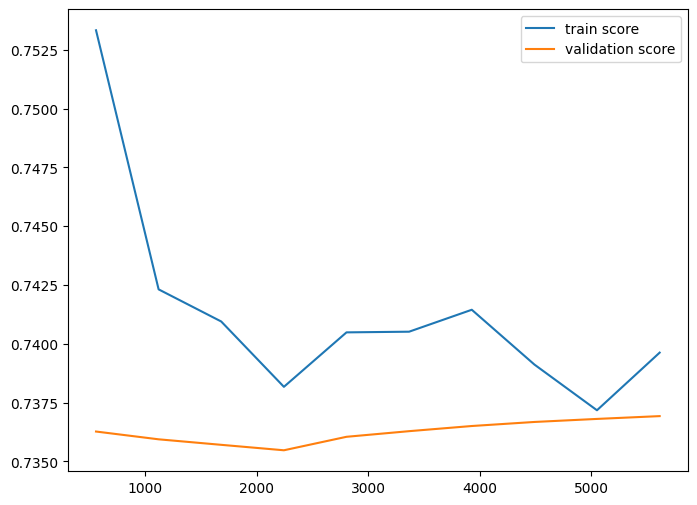

In [135]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

ridge = Ridge(alpha=0.1)

ridge_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(ridge_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(ridge_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(ridge, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

ridge.fit(X_train,y_train)

In [136]:
y_pred = ridge.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.7261061253493926


MAS =  0.3546161444323798


MSE =  0.27389387465060755






In [137]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

ridge_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(ridge_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(ridge_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha":np.linspace(0.01,0.1,20)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = Ridge(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': np.float64(0.04789473684210527)}


Best r2 : 0.8751908893919964


Best param for ridge are:-
{'alpha': np.float64(0.04315789473684211)}


Best neg_root_mean_squared_error : -0.35290125082403356




Ridge(alpha=0.04)

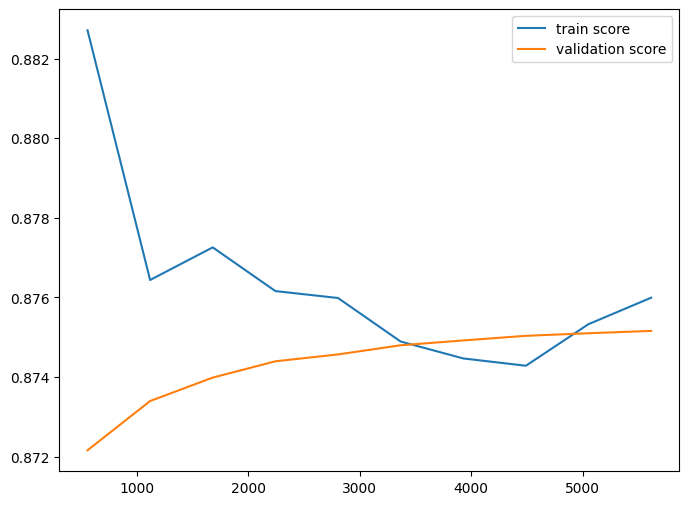

In [138]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

ridge = Ridge(alpha=0.04)

ridge_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(ridge_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(ridge_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(ridge, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

ridge.fit(X_train,y_train)

In [139]:
y_pred = ridge.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.8736154297327133


MAS =  0.2755346829659057


MSE =  0.1263845702672867






<h4>Lasso Regression</h4>

In [140]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

lasso_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(lasso_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(lasso_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha":np.linspace(0.01,0.1,20)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = Lasso(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': np.float64(0.01)}


Best r2 : 0.7335693049200306


Best param for ridge are:-
{'alpha': np.float64(0.01)}


Best neg_root_mean_squared_error : -0.5156033273584312




Lasso(alpha=0.01)

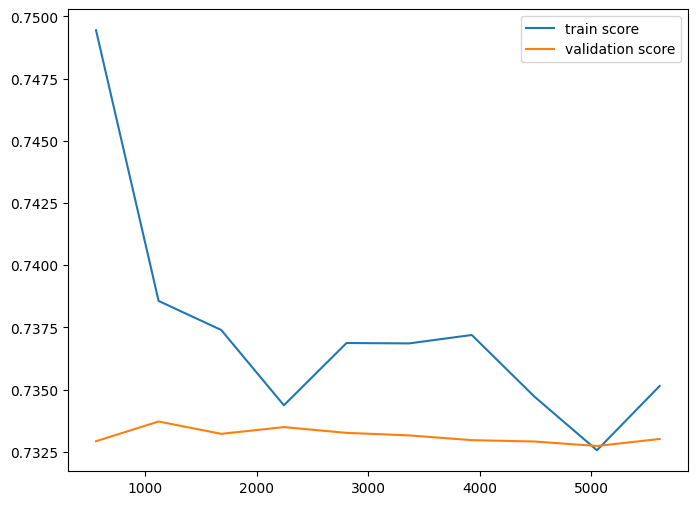

In [141]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

lasso = Lasso(alpha=0.01)

lasso_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(lasso_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(lasso_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(lasso, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

lasso.fit(X_train,y_train)

In [142]:
y_pred = lasso.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.7220787244974921


MAS =  0.3630768520702395


MSE =  0.27792127550250795






In [143]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

lasso_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(lasso_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(lasso_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha":np.linspace(0.01,0.1,20)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = Lasso(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': np.float64(0.01)}


Best r2 : 0.8709662691407252


Best param for ridge are:-
{'alpha': np.float64(0.01)}


Best neg_root_mean_squared_error : -0.3587905075243024




Lasso(alpha=0.01)

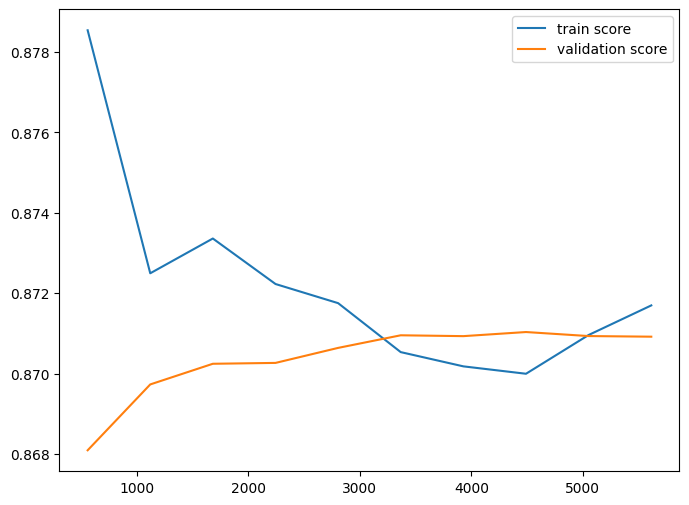

In [144]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

lasso = Lasso(alpha=0.01)

lasso_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(lasso_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(lasso_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(lasso, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

lasso.fit(X_train,y_train)

In [145]:
y_pred = lasso.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.8703385897465402


MAS =  0.2796240435600613


MSE =  0.1296614102534598






<h4>ElasticNet Regression</h4>

In [146]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

elasticnet_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(elasticnet_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(elasticnet_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"l1_ratio": np.arange(0.0, 1.0, 0.1)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = ElasticNet(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': 0.0001, 'l1_ratio': np.float64(0.0)}


Best r2 : 0.737601968340176


Best param for ridge are:-
{'alpha': 0.0001, 'l1_ratio': np.float64(0.0)}


Best neg_root_mean_squared_error : -0.5116764879314617




ElasticNet(alpha=0.0001, l1_ratio=0.0)

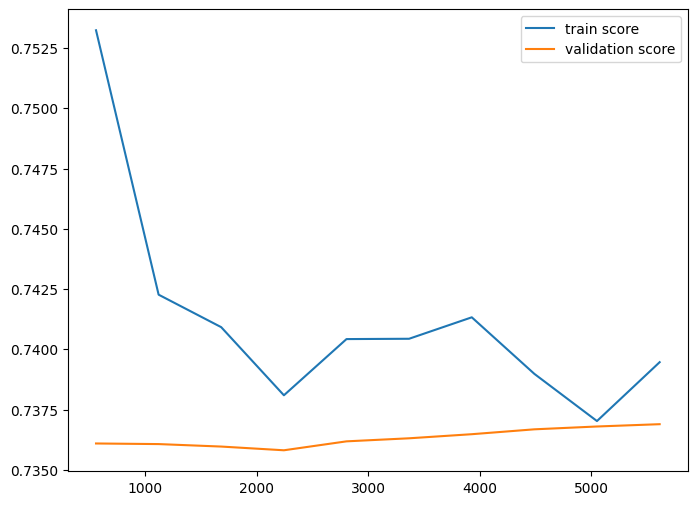

In [147]:
response = target_class[0]

X_train = df_train.copy()
X_test = df_test.copy()

elastic_net = ElasticNet(alpha=0.0001,l1_ratio=0.0)

elasticnet_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(elasticnet_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(elasticnet_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(elastic_net, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

elastic_net.fit(X_train,y_train)

In [148]:
y_pred = elastic_net.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.7260229627518973


MAS =  0.35443707288668697


MSE =  0.2739770372481029






In [149]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

elasticnet_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(elasticnet_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(elasticnet_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

hyper_parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"l1_ratio": np.arange(0.0, 1.0, 0.1)}
scoring = ["r2","neg_root_mean_squared_error"]
for metric in scoring:
  clf = GridSearchCV(estimator = ElasticNet(),param_grid=hyper_parameters,scoring = metric)

  clf.fit(X_train,y_train)
  
  print("Best param for ridge are:-")
  print(clf.best_params_)
  print("\n")
  print("Best {} : {}".format(metric,clf.best_score_))
  print("\n")

Best param for ridge are:-
{'alpha': 0.0001, 'l1_ratio': np.float64(0.0)}


Best r2 : 0.8750920535298026


Best param for ridge are:-
{'alpha': 0.0001, 'l1_ratio': np.float64(0.0)}


Best neg_root_mean_squared_error : -0.3530413953723544




ElasticNet(alpha=0.0001, l1_ratio=0.0)

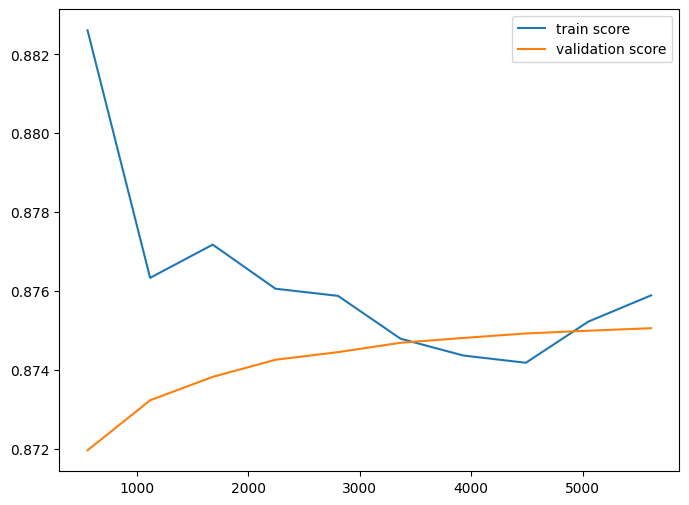

In [150]:
response = target_class[1]

X_train = df_train.copy()
X_test = df_test.copy()

elastic_net = ElasticNet(alpha=0.0001,l1_ratio=0.0)

elasticnet_pipline = make_pipeline(drop_feat,mean_impute,skew_scale,std_scaler)

X_train = pd.DataFrame(elasticnet_pipline.fit_transform(X_train),columns=num_cols)
X_test = pd.DataFrame(elasticnet_pipline.fit_transform(X_test),columns=num_cols)

y_train = X_train[response].copy()
X_train = X_train.drop(response,axis=1)

y_test = X_test[response].copy()
X_test = X_test.drop(response,axis=1)

N, train_score, val_score = learning_curve(elastic_net, X_train, y_train, cv=4, scoring="r2", train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

elastic_net.fit(X_train,y_train)

In [151]:
y_pred = elastic_net.predict(X_test)

all_scores.append(evaluation(y_pred,y_test))
print("\n")

R2 score =  0.8733456990718323


MAS =  0.2758744832149236


MSE =  0.12665430092816768






<h4> Conclusion </h4>

In [161]:
all_scores_pollutant_1 = all_scores[0::2]
all_scores_pollutant_2 = all_scores[1::2]

all_scores_pollutant_1 = pd.DataFrame(np.array(all_scores_pollutant_1),columns=["R2","MAS","MSE"],index=["Ridge","Lasso","ElasticNet"])
all_scores_pollutant_2 = pd.DataFrame(np.array(all_scores_pollutant_2),columns=["R2","MAS","MSE"],index=["Ridge","Lasso","ElasticNet"])

print("Pollutant 1: {}".format(target_class[0]))
display(all_scores_pollutant_1)
print("\n")
print("Pollutant 2: {}".format(target_class[1]))
display(all_scores_pollutant_2)

Pollutant 1: CO(GT)


R2       MAS       MSE
Ridge       0.726106  0.354616  0.273894
Lasso       0.722079  0.363077  0.277921
ElasticNet  0.726023  0.354437  0.273977



Pollutant 2: PT08.S1(CO)


R2       MAS       MSE
Ridge       0.873615  0.275535  0.126385
Lasso       0.870339  0.279624  0.129661
ElasticNet  0.873346  0.275874  0.126654